In [3]:
import pandas as pd
import spacy
import re

In [4]:
train_dataset = pd.read_csv("data/train_cleaned.csv")
validation_dataset = pd.read_csv("data/validation_cleaned.csv")

In [5]:
nlp = spacy.load("en_core_web_sm")

In [6]:
text = re.sub(r'[0-9]+', 'NUM', "DOW raised by 19%")
text

'DOW raised by NUM%'

In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    text = re.sub(r'[0-9]+', 'NUM', text)
    doc = nlp(text)
    lemmatized_text = " ". join([token.lemma_.strip() for token in doc])
    return lemmatized_text

train_dataset["cleaned_text"] = train_dataset["text"].map(clean_text)
validation_dataset["cleaned_text"] = validation_dataset["text"].map(clean_text)

In [10]:
train_dataset.iloc[45]

text            Berry Petroleum downgraded to market perform f...
label                                                           0
word_count                                                     11
char_count                                                     75
cleaned_text    berry petroleum downgrade to market perform fr...
Name: 45, dtype: object

In [8]:
X_train = train_dataset["cleaned_text"].values
y_train = train_dataset["label"].values
X_test = validation_dataset["cleaned_text"].values
y_test = validation_dataset["label"].values

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

baseline_model = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000, 
        stop_words='english', 
        ngram_range=(1, 2) # Includes single words and 2-word phrases
    )),
    ('clf', LogisticRegression(max_iter=500, class_weight='balanced')) # Helpful for imbalance!
])

# 2. Fit on Training Data
baseline_model.fit(X_train, y_train)

# 3. Evaluate on Test (It will use the Train vocabulary automatically)
y_pred = baseline_model.predict(X_test)

In [10]:
y_pred.shape

(1910,)

In [25]:
def get_sample_weight_dict(df):
    rating_counts = df['label'].value_counts()
    print(f"rating value counts === {rating_counts}")
    max_rating_count = rating_counts.max()
    print(f"max rating count === {max_rating_count}")
    weight_dict = (max_rating_count / rating_counts).to_dict()
    print(f"weight_dict === {weight_dict}")
    return weight_dict

sample_weight_dict = get_sample_weight_dict(validation_dataset)
val_sample_weights = validation_dataset['label'].map(sample_weight_dict)

rating value counts === label
2    1252
1     380
0     278
Name: count, dtype: int64
max rating count === 1252
weight_dict === {2: 1.0, 1: 3.294736842105263, 0: 4.503597122302159}


In [11]:
from sklearn.metrics import log_loss, precision_score, recall_score, f1_score, balanced_accuracy_score, confusion_matrix,ConfusionMatrixDisplay
def compute_metrics(preds, labels):
    f1_weighted = f1_score(y_true=labels, y_pred=preds, average='weighted')
    precision_weighted = precision_score(y_true=labels, y_pred=preds, average='weighted')
    recall_weighted = recall_score(y_true=labels, y_pred=preds, average='weighted')
    accuracy_weighted = balanced_accuracy_score(y_true=labels, y_pred=preds)
    f1_macro = f1_score(y_true=labels, y_pred=preds, average='macro')
    precision_macro = precision_score(y_true=labels, y_pred=preds, average='macro')
    recall_macro = recall_score(y_true=labels, y_pred=preds, average='macro')
    metrics = {
        "f1_weighted": f1_weighted, 
        "f1_macro": f1_macro,
        "precision_weighted": precision_weighted, 
        "precision_macro": precision_macro,
        "recall_weighted": recall_weighted, 
        "recall_macro": recall_macro,
        "accuracy": accuracy_weighted,
    }    
    return metrics

In [12]:
metrics = compute_metrics(y_pred, y_test)
metrics

{'f1_weighted': 0.8085738676514773,
 'f1_macro': 0.7510659645248142,
 'precision_weighted': 0.8233866267942209,
 'precision_macro': 0.7287637814664247,
 'recall_weighted': 0.8020942408376963,
 'recall_macro': 0.7852543188250812,
 'accuracy': 0.7852543188250812}

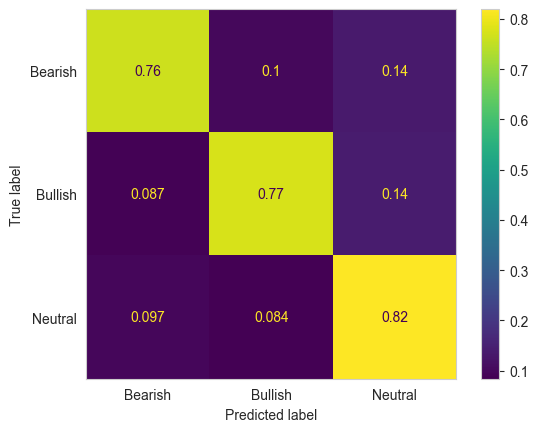

In [35]:
from matplotlib import pyplot as plt

cm = confusion_matrix(y_test, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Bearish", "Bullish", "Neutral"])
disp.plot()
plt.grid(False)
plt.show()

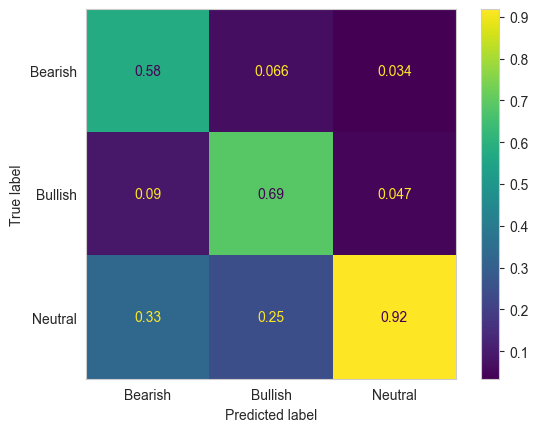

In [37]:
from matplotlib import pyplot as plt

cm = confusion_matrix(y_test, y_pred, normalize="pred")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Bearish", "Bullish", "Neutral"])
disp.plot()
plt.grid(False)
plt.show()